In [1]:
import pandas as pd, numpy as np, datetime as dt, os, operator
import sqlalchemy as sql, seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN

In [ ]:
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

In [3]:
engine = sql.create_engine("sqlite:///../src/data/music.db")
with engine.connect() as con:
    attributes = pd.read_sql("SELECT * FROM attributes", con=con)

In [4]:
classifies_df = attributes.loc[:, ["Song", "Performer", "danceability", "acousticness","energy", "speechiness", 'instrumentalness', 'liveness', 'valence', # [0, 1] continuous variables
'tempo', "loudness", 'duration', # specific intervals continuous variables 
'timesignature', 'mode','explicit', "chart", 'genre_super']] # categorical variables

In [5]:
classifies_df = classifies_df.assign(genre_super = lambda x: x.genre_super.apply(lambda g: g if g not in ["empty", "missing"] else "other"))

In [6]:
classifies_df = classifies_df.dropna()

In [7]:
X = classifies_df.iloc[:, 2:-2].values
y = classifies_df.iloc[:, -2].values

In [8]:
1 - classifies_df.iloc[:, -2].mean()

0.623335011672083

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5, shuffle=True)

In [10]:
rf_chart = RandomForestClassifier(n_estimators=200)
rf_chart = rf_chart.fit(X_train, y_train)

In [11]:
clf_chart = tree.DecisionTreeClassifier()
clf_chart = clf_chart.fit(X_train, y_train)

In [12]:
clf_sv_chart = svm.SVC()
clf_sv_chart = clf_sv_chart.fit(X_train, y_train)

In [13]:
knn_chart = KNeighborsClassifier(2)
knn_chart = knn_chart.fit(X_train, y_train)

In [14]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_chart, clf_chart, clf_sv_chart, knn_chart]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 61.99722607489597% Correctly Classified
DECISION TREE : 54.0499306518724% Correctly Classified
SUPPORT VECTOR : 62.62135922330098% Correctly Classified
K-Nearest Neighbors : 59.68099861303745% Correctly Classified


In [15]:
chart_class_df = pd.DataFrame(zip(knn_chart.predict(X_test), clf_chart.predict(X_test), rf_chart.predict(X_test), clf_sv_chart.predict(X_test), y_test), columns=["knn", "decision_tree", "random_forest", "svm","chart"])
chart_class_df= chart_class_df.assign(knn_bin = lambda x: (x.knn == x.chart).astype("int"))
chart_class_df= chart_class_df.assign(dt_bin = lambda x: (x.decision_tree == x.chart).astype("int"))
chart_class_df= chart_class_df.assign(rf_bin = lambda x: (x.random_forest == x.chart).astype("int"))
chart_class_df= chart_class_df.assign(svm_bin = lambda x: (x.svm == x.chart).astype("int"))
chart_class_df = chart_class_df.assign(preds = lambda x: x.iloc[:, -4:].sum(axis=1))

In [16]:
genre_dict = {g:i for i, g in zip(range(1, 15), classifies_df.genre_super.unique())}

In [17]:
genre_test = classifies_df.assign(genre_class = lambda x: x.genre_super.apply(lambda g: genre_dict[g]))

In [18]:
y_2 = genre_test.genre_class.values
X_2 = genre_test.iloc[:, 2:16].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, random_state=12, test_size=0.33,shuffle=True)

In [20]:
clf_genre = tree.DecisionTreeClassifier()
clf_genre = clf_genre.fit(X_train, y_train)

In [21]:
rf_genre = RandomForestClassifier(n_estimators=200)
rf_genre = rf_genre.fit(X_train, y_train)

In [22]:
knn_genre = KNeighborsClassifier(14)
knn_genre = knn_genre.fit(X_train, y_train)

In [23]:
clf_sv_genre = svm.SVC()
clf_sv_genre = clf_sv_genre.fit(X_train, y_train)

In [24]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_genre, clf_genre, clf_sv_genre, knn_genre]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 54.25797503467407% Correctly Classified
DECISION TREE : 39.2371705963939% Correctly Classified
SUPPORT VECTOR : 28.307905686546462% Correctly Classified
K-Nearest Neighbors : 26.130374479889042% Correctly Classified


In [25]:
chart_class_df.groupby("preds").mean()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin
preds,,,,,,,,,
0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.232456,0.650877,0.216667,0.0,0.950000,0.182456,0.600877,0.166667,0.050000
2,0.435359,0.910497,0.654144,0.0,0.444199,0.469613,0.449724,0.524862,0.555801
3,0.217585,0.698943,0.142460,0.0,0.029494,0.811909,0.330551,0.887034,0.970506
4,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
chart_class_df.groupby("preds").count()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin
preds,,,,,,,,,
0,1157,1157,1157,1157,1157,1157,1157,1157,1157
1,1140,1140,1140,1140,1140,1140,1140,1140,1140
2,905,905,905,905,905,905,905,905,905
3,1797,1797,1797,1797,1797,1797,1797,1797,1797
4,2211,2211,2211,2211,2211,2211,2211,2211,2211


In [27]:
chart_class_df.groupby("preds").count()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin
preds,,,,,,,,,
0,1157,1157,1157,1157,1157,1157,1157,1157,1157
1,1140,1140,1140,1140,1140,1140,1140,1140,1140
2,905,905,905,905,905,905,905,905,905
3,1797,1797,1797,1797,1797,1797,1797,1797,1797
4,2211,2211,2211,2211,2211,2211,2211,2211,2211


In [28]:
chart_class_df.groupby("random_forest").mean()

,knn,decision_tree,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin,preds
random_forest,,,,,,,,,
0.0,0.140474,0.359935,0.0,0.354865,0.611938,0.548487,0.645135,0.645135,2.450695
1.0,0.174429,0.567123,0.0,0.479452,0.512329,0.495890,0.479452,0.520548,2.008219


In [29]:
chart_class_df.loc[:, ["knn", "decision_tree", "random_forest", "svm","chart"]].mean()

knn              0.145631
decision_tree    0.391401
random_forest    0.151872
svm              0.000000
chart            0.373786
dtype: float64

In [30]:
chart_class_df.describe()

,knn,decision_tree,random_forest,svm,chart,knn_bin,dt_bin,rf_bin,svm_bin,preds
count,7210.000000,7210.000000,7210.000000,7210.0,7210.000000,7210.000000,7210.000000,7210.000000,7210.000000,7210.000000
mean,0.145631,0.391401,0.151872,0.0,0.373786,0.596810,0.540499,0.619972,0.626214,2.383495
std,0.352760,0.488098,0.358922,0.0,0.483842,0.490572,0.498392,0.485427,0.483842,1.459141
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
75%,0.000000,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


In [31]:
# scale non-[0,1] intervals to [0,1] {tempo, duration, loudness}
# scale categorical attributes to [0, 1] by category number / max category number

In [32]:
classifies_df = classifies_df.assign(timesignature = lambda x: x.timesignature.apply(lambda f: f / x.timesignature.max()))\
    .assign(tempo = lambda x: x.tempo.apply(lambda j: j/x.tempo.max()))\
        .assign(duration = lambda x: x.duration.apply(lambda d: d / x.duration.max()))\
            .assign(loudness = lambda x: x.loudness.apply(lambda l: l / x.loudness.min()))

In [33]:
genre_test = classifies_df.assign(genre_class = lambda x: x.genre_super.apply(lambda g: genre_dict[g]))

In [34]:
X = classifies_df.iloc[:, 2:-2].values
y = classifies_df.iloc[:, -2].values

In [35]:
1 - classifies_df.iloc[:, -2].mean()

0.623335011672083

In [36]:
# Reruning chart classification with scaled categorical attributes

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5, shuffle=True)

In [38]:
rf_chart = RandomForestClassifier(n_estimators=200)
rf_chart = rf_chart.fit(X_train, y_train)

In [39]:
clf_chart = tree.DecisionTreeClassifier()
clf_chart = clf_chart.fit(X_train, y_train)

In [40]:
clf_sv_chart = svm.SVC()
clf_sv_chart = clf_sv_chart.fit(X_train, y_train)

In [41]:
knn_chart = KNeighborsClassifier(2)
knn_chart = knn_chart.fit(X_train, y_train)

In [42]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_chart, clf_chart, clf_sv_chart, knn_chart]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 61.91400832177531% Correctly Classified
DECISION TREE : 54.21636615811373% Correctly Classified
SUPPORT VECTOR : 62.62135922330098% Correctly Classified
K-Nearest Neighbors : 59.05686546463246% Correctly Classified


In [43]:
y_2 = genre_test.genre_class.values
X_2 = genre_test.iloc[:, 2:16].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, random_state=12, test_size=0.33,shuffle=True)

In [45]:
clf_genre = tree.DecisionTreeClassifier()
clf_genre = clf_genre.fit(X_train, y_train)

In [46]:
rf_genre = RandomForestClassifier(n_estimators=200)
rf_genre = rf_genre.fit(X_train, y_train)

In [47]:
knn_genre = KNeighborsClassifier(14)
knn_genre = knn_genre.fit(X_train, y_train)

In [48]:
clf_sv_genre = svm.SVC()
clf_sv_genre = clf_sv_genre.fit(X_train, y_train)

In [49]:
for n, m in zip(["RANDOM FOREST", "DECISION TREE", "SUPPORT VECTOR", "K-Nearest Neighbors"], [rf_genre, clf_genre, clf_sv_genre, knn_genre]):
    print(f"{n} : {m.score(X_test, y_test)*100}% Correctly Classified")

RANDOM FOREST : 53.93897364771151% Correctly Classified
DECISION TREE : 39.29264909847434% Correctly Classified
SUPPORT VECTOR : 48.84882108183079% Correctly Classified
K-Nearest Neighbors : 47.57281553398058% Correctly Classified


In [50]:
genre_class_df = pd.DataFrame(zip(knn_genre.predict(X_test), clf_genre.predict(X_test), rf_genre.predict(X_test), clf_sv_genre.predict(X_test), y_test), columns=["knn", "decision_tree", "random_forest", "svm","genre"])
genre_class_df= genre_class_df.assign(knn_bin = lambda x: (x.knn == x.genre).astype("int"))
genre_class_df= genre_class_df.assign(dt_bin = lambda x: (x.decision_tree == x.genre).astype("int"))
genre_class_df= genre_class_df.assign(rf_bin = lambda x: (x.random_forest == x.genre).astype("int"))
genre_class_df= genre_class_df.assign(svm_bin = lambda x: (x.svm == x.genre).astype("int"))
genre_class_df = genre_class_df.assign(preds = lambda x: x.iloc[:, -4:].sum(axis=1))

In [51]:
genre_parse = {v:k for k,v in genre_dict.items()}

In [52]:
genre_class_df.assign(genre_name = lambda x: x.genre.apply(lambda t: genre_parse[t])).groupby("genre_name").mean()

,knn,decision_tree,random_forest,svm,genre,knn_bin,dt_bin,rf_bin,svm_bin,preds
genre_name,,,,,,,,,,
christian,3.333333,4.166667,2.857143,2.809524,8.0,0.000000,0.000000,0.000000,0.000000,0.000000
country,2.762552,3.899582,2.817992,2.639121,3.0,0.509414,0.414226,0.602510,0.451883,1.978033
electronic,3.534351,5.465649,3.916031,3.244275,10.0,0.101781,0.206107,0.137405,0.066158,0.511450
indie,2.906780,3.754237,3.355932,2.796610,4.0,0.033898,0.033898,0.016949,0.000000,0.084746
jazz,2.750000,7.500000,5.000000,3.250000,13.0,0.000000,0.000000,0.000000,0.000000,0.000000
latin,3.122905,5.022346,3.044693,2.441341,11.0,0.061453,0.139665,0.033520,0.000000,0.234637
metal,4.307692,4.956044,4.703297,4.318681,9.0,0.000000,0.131868,0.065934,0.000000,0.197802
other,3.257576,5.545455,3.287879,3.181818,7.0,0.030303,0.015152,0.030303,0.060606,0.136364
pop,3.025713,4.351593,3.000000,2.880939,2.0,0.572946,0.371716,0.615428,0.682504,2.242594


In [53]:
genre_class_df = genre_class_df.assign(genre_name = lambda x: x.genre.apply(lambda t: genre_parse[t]))

In [59]:
genre_classed = pd.DataFrame(zip(knn_genre.predict(classifies_df.iloc[:, 2:-1].values), clf_genre.predict(classifies_df.iloc[:, 2:-1].values), rf_genre.predict(classifies_df.iloc[:, 2:-1].values), clf_sv_genre.predict(classifies_df.iloc[:, 2:-1].values), y_2), columns=["knn", "decision_tree", "random_forest", "svm","genre"])

In [60]:
genre_classed.knn=genre_classed.knn.apply(lambda x: genre_parse[x])
genre_classed.svm=genre_classed.svm.apply(lambda x: genre_parse[x])
genre_classed.decision_tree=genre_classed.decision_tree.apply(lambda x: genre_parse[x])
genre_classed.random_forest=genre_classed.random_forest.apply(lambda x: genre_parse[x])
genre_classed.genre = genre_classed.genre.apply(lambda x: genre_parse[x])

In [63]:
df_class_and_attr = pd.concat([genre_test, genre_classed], axis=1)

In [64]:
df_class_and_attr.to_csv("class_and_attr.csv", index=False)

In [75]:
df_class_and_attr.groupby(["genre_super", "random_forest"]).count()[lambda x: x.index == ("pop", "pop")].iloc[:, :1].sort_values("Song", ascending=False)

,,Song
genre_super,random_forest,
pop,pop,1896


In [78]:
df_class_and_attr.groupby(["genre_super", "knn"]).count()[lambda x: x.index == ("pop", "pop")].iloc[:, :1].sort_values("Song", ascending=False)

,,Song
genre_super,knn,
pop,pop,2474


In [79]:
df_class_and_attr.groupby(["genre_super", "svm"]).count()[lambda x: x.index == ("pop", "pop")].iloc[:, :1].sort_values("Song", ascending=False)

,,Song
genre_super,svm,
pop,pop,3013


In [81]:
df_class_and_attr.groupby(["genre_super", "decision_tree"]).count()[lambda x: x.index == ("pop", "pop")].iloc[:, :1].sort_values("Song", ascending=False)

,,Song
genre_super,decision_tree,
pop,pop,1655


In [83]:
attributes.columns

Index(['Song', 'Performer', 'SongID', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'timesignature', 'duration', 'id_y',
       'explicit', 'popularity', 'release_date', 'chart', 'id_fk', 'genre',
       'genre_super', 'transform', 'bill_popularity', 'scaled_popularity'],
      dtype='object')

In [85]:
df_class_and_attr.columns

Index(['Song', 'Performer', 'danceability', 'acousticness', 'energy',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'loudness', 'duration', 'timesignature', 'mode', 'explicit', 'chart',
       'genre_super', 'genre_class', 'knn', 'decision_tree', 'random_forest',
       'svm', 'genre'],
      dtype='object')

In [86]:
set(attributes.columns).difference(set(df_class_and_attr.columns))

{'SongID',
 'bill_popularity',
 'id',
 'id_fk',
 'id_y',
 'key',
 'popularity',
 'release_date',
 'scaled_popularity',
 'transform'}

In [89]:
attr_class = attributes.loc[:, ["Song","Performer", "key", "bill_popularity", "scaled_popularity","popularity", "release_date"]].merge(df_class_and_attr, "left", on=["Song", "Performer"])

In [90]:
attr_class.to_csv("class_and_attr.csv", index=False)

In [102]:
keys = attr_class.groupby(["key", "genre_super"]).count().sort_index(level=0).merge(attr_class.groupby("key").count().iloc[:, :1], "left", left_index=True, right_index=True).loc[:, ["Song_x", "Song_y"]]

In [119]:
# Songs that Live on (brief appearence on the billboard chart with current high popularity)
# Descrepancy between the normal dist of popularity and semi-normal transform of the exponential cumulative bill popularity 
attr_class.sort_values(["bill_popularity"], ascending=False).dropna().assign(g = lambda x: x.scaled_popularity - x.popularity).sort_values("g").loc[:, ["Song", "Performer", "bill_popularity", "scaled_popularity", "popularity","g"]].head(25)

,Song,Performer,bill_popularity,scaled_popularity,popularity,g
5947,like i can,sam smith,4.0,25.0,86.0,-61.0
8079,she,harry styles,2.0,23.0,77.0,-54.0
7826,summer days,martin garrix featuring macklemore & patrick s...,1.0,21.0,75.0,-54.0
6411,nights,frank ocean,3.0,24.0,78.0,-54.0
5667,the days,avicii,23.0,33.0,86.0,-53.0
6562,hate u love u,olivia o'brien,2.0,23.0,76.0,-53.0
8131,otro trago,sech featuring darell,1.0,21.0,73.0,-52.0
7931,love me,lil tecca,4.0,25.0,77.0,-52.0
2211,ella y yo,aventura featuring don omar,4.0,25.0,77.0,-52.0
7606,idontwannabeyouanymore,billie eilish,9.0,28.0,79.0,-51.0


In [131]:
# The Songs We've Forgotten (on Spotify but whose popularity as told by the song's time on the chart has the largest descrepancy vs. their Spotify Popularity today)
attr_class.sort_values(["bill_popularity"], ascending=False).dropna().assign(g = lambda x: x.scaled_popularity - x.popularity).sort_values("g", ascending=False).loc[:, ["Song", "Performer", "bill_popularity", "scaled_popularity", "popularity","g"]].head(25)

,Song,Performer,bill_popularity,scaled_popularity,popularity,g
1262,miss you,aaliyah,2529.0,76.0,2.0,74.0
3744,your love is my drug,ke$ha,2002.0,73.0,0.0,73.0
479,try again,aaliyah,2699.0,77.0,5.0,72.0
4147,blow,ke$ha,1916.0,72.0,0.0,72.0
3011,bust it baby part 2,plies featuring ne-yo,1728.0,71.0,0.0,71.0
2632,2 step,unk,1242.0,67.0,0.0,67.0
4101,we r who we r,ke$ha,1770.0,71.0,4.0,67.0
3745,take it off,ke$ha,1371.0,68.0,1.0,67.0
2257,for you i will (confidence),teddy geiger,1106.0,66.0,0.0,66.0
1049,pass the courvoisier part ii,busta rhymes featuring p. diddy & pharrell,1349.0,68.0,3.0,65.0


In [146]:
attr_class.dropna()[lambda x: x.bill_popularity >= 1000].sort_values('bill_popularity', ascending=False).value_counts("genre_super")

genre_super
pop           789
rap           534
r&b           226
country       202
rock          173
electronic     72
metal          12
latin          11
indie           9
soundtrack      8
other           6
reggae          5
christian       3
jazz            2
dtype: int64

In [158]:
attr_class.release_date = pd.to_datetime(attr_class.release_date)

In [108]:
keys.assign(pct = lambda x: (x.Song_x / x.Song_y)*100).sort_values("pct", ascending=False).head(25)

,,Song_x,Song_y,pct
key,genre_super,,,
1.0,rap,1026,2720,37.720588
0.0,pop,743,2378,31.244743
10.0,rap,453,1503,30.139721
8.0,rap,489,1629,30.018416
11.0,rap,550,1890,29.100529
5.0,pop,506,1753,28.864803
3.0,pop,175,627,27.910686
8.0,pop,430,1629,26.396562
7.0,pop,599,2280,26.271930


In [160]:
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31)))].value_counts("explicit", True)

explicit
0.0    0.788314
1.0    0.211686
dtype: float64

In [162]:
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31)))].value_counts("genre_super", True)

genre_super
pop           0.244962
rap           0.218403
rock          0.147008
country       0.138260
r&b           0.103734
electronic    0.035307
soundtrack    0.025777
metal         0.024684
latin         0.021403
indie         0.015623
other         0.009217
christian     0.009061
reggae        0.005155
jazz          0.001406
dtype: float64

In [164]:
attr_class[lambda x: ((x.release_date >= dt.datetime(1999, 1, 1))&(x.release_date <= dt.datetime(2009, 12, 31)))].value_counts("chart")

chart
1.0    3450
0.0    2951
dtype: int64

In [161]:
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31)))].value_counts("explicit", True)

explicit
0.0    0.65311
1.0    0.34689
dtype: float64

In [163]:
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31)))].value_counts("genre_super", True)

genre_super
rap           0.286751
pop           0.286504
country       0.121020
electronic    0.065996
rock          0.065418
r&b           0.057251
soundtrack    0.043475
latin         0.030028
indie         0.016169
other         0.012044
metal         0.007012
christian     0.005445
reggae        0.002475
jazz          0.000412
dtype: float64

In [166]:
attr_class[lambda x: ((x.release_date >= dt.datetime(2010, 1, 1))&(x.release_date <= dt.datetime(2019, 12, 31)))].value_counts("chart")

chart
0.0    7638
1.0    4484
dtype: int64

In [171]:
attr_class = attr_class.assign(release_year = lambda x: x.release_date.apply(lambda r: r.year))

In [175]:
attr_class.assign(half = lambda x: x.release_year.apply(lambda a: 1 if a < 2010 else 2)).groupby(['half', 'genre_super']).mean().sort_index(level=1)

,,key,bill_popularity,scaled_popularity,popularity,danceability,acousticness,energy,speechiness,instrumentalness,liveness,valence,tempo,loudness,duration,timesignature,mode,explicit,chart,genre_class,release_year
half,genre_super,,,,,,,,,,,,,,,,,,,,
1,christian,4.943662,364.625000,47.687500,41.957746,0.488310,0.214958,0.666324,0.049445,0.004807,0.189465,0.418903,0.566144,0.149535,0.211859,0.794366,0.830986,0.000000,0.225352,8.0,2002.577465
2,christian,4.864865,308.250000,41.250000,49.351351,0.487905,0.423786,0.520919,0.055657,0.000504,0.163224,0.341746,0.531699,0.165755,0.202215,0.770270,0.864865,0.000000,0.108108,8.0,2015.689189
1,country,5.246845,612.399718,56.124294,44.190063,0.571650,0.270373,0.626114,0.037296,0.001220,0.173587,0.517179,0.575086,0.166317,0.190726,0.789432,0.947161,0.002366,0.558360,3.0,2000.739748
2,country,5.099105,587.365359,54.558863,48.449488,0.561047,0.208375,0.697277,0.043625,0.002032,0.167600,0.526751,0.582420,0.131479,0.181330,0.788235,0.888747,0.008312,0.472506,3.0,2014.877238
1,electronic,5.838462,634.459459,51.472973,47.400000,0.669042,0.088503,0.783885,0.084710,0.130708,0.211147,0.593921,0.586524,0.147645,0.214382,0.800000,0.565385,0.073077,0.284615,10.0,2003.888462
2,electronic,5.388498,844.234940,53.313253,52.890845,0.644871,0.129254,0.755810,0.081413,0.070215,0.196350,0.482758,0.562468,0.118943,0.184649,0.799765,0.539906,0.125587,0.194836,10.0,2015.387324
1,indie,5.283019,491.240000,50.440000,50.389937,0.543969,0.389483,0.545810,0.043371,0.034582,0.150886,0.494843,0.566206,0.199047,0.205236,0.778616,0.849057,0.025157,0.157233,4.0,1999.415094
2,indie,5.382488,329.600000,39.440000,46.746544,0.526378,0.370250,0.539399,0.052194,0.066806,0.171553,0.415408,0.550371,0.189567,0.191361,0.771429,0.778802,0.032258,0.115207,4.0,2015.156682
1,jazz,5.526316,983.666667,57.000000,57.736842,0.530632,0.754737,0.318316,0.045168,0.086659,0.134147,0.471216,0.539938,0.293193,0.189306,0.789474,0.526316,0.000000,0.157895,13.0,1983.947368


In [177]:
attr_class[lambda x: x.chart > 0].assign(half = lambda x: x.release_year.apply(lambda a: 1 if a < 2010 else 2)).groupby(['half', 'genre_super']).count().sort_index(level=1)

,,Song,Performer,key,bill_popularity,scaled_popularity,popularity,release_date,danceability,acousticness,energy,...,mode,explicit,chart,genre_class,knn,decision_tree,random_forest,svm,genre,release_year
half,genre_super,,,,,,,,,,,,,,,,,,,,,
1,christian,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
2,christian,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
1,country,708,708,708,708,708,708,708,708,708,708,...,708,708,708,708,708,708,708,708,708,708
2,country,739,739,739,739,739,739,739,739,739,739,...,739,739,739,739,739,739,739,739,739,739
1,electronic,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,73,73,73,73,73,74
2,electronic,166,166,166,166,166,166,166,166,166,166,...,166,166,166,166,165,165,165,165,165,166
1,indie,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
2,indie,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
1,jazz,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


<AxesSubplot:ylabel='Frequency'>

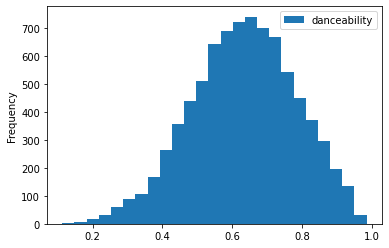

In [193]:
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="danceability", bins=25)

<AxesSubplot:ylabel='Frequency'>

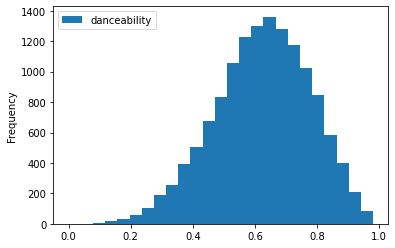

In [191]:
attr_class[lambda x: x.chart <= 0].plot(kind="hist", y="danceability", bins=25)

<AxesSubplot:ylabel='Frequency'>

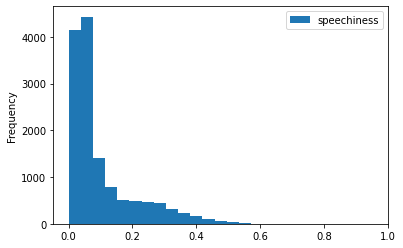

In [194]:
attr_class[lambda x: x.chart <= 0].plot(kind="hist", y="speechiness", bins=25)

<AxesSubplot:ylabel='Frequency'>

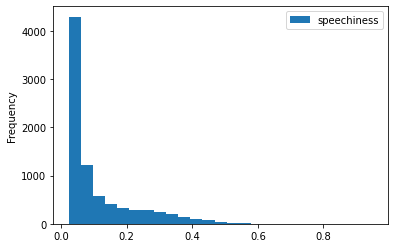

In [195]:
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="speechiness", bins=25)

<AxesSubplot:ylabel='Frequency'>

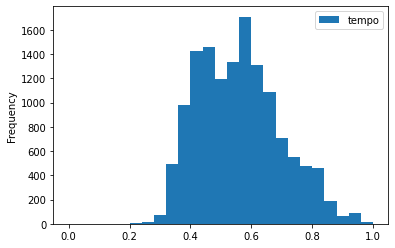

In [196]:
attr_class[lambda x: x.chart <= 0].plot(kind="hist", y="tempo", bins=25)

<AxesSubplot:ylabel='Frequency'>

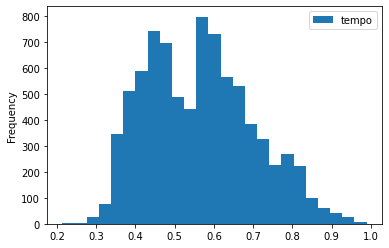

In [197]:
attr_class[lambda x: x.chart > 0].plot(kind="hist", y="tempo", bins=25)

In [221]:
df_class_and_attr.loc[:, ["Song", "Performer", "genre_super", "knn", "svm", "decision_tree", "random_forest","genre"]].dropna()

,Song,Performer,genre_super,knn,svm,decision_tree,random_forest,genre
0,i'm your angel,r. kelly & celine dion,r&b,country,country,country,pop,r&b
1,nobody's supposed to be here,deborah cox,r&b,pop,pop,r&b,r&b,r&b
2,lately,divine,pop,country,country,pop,pop,pop
3,...baby one more time,britney spears,pop,pop,pop,pop,pop,pop
4,because of you,98 degrees,pop,country,country,pop,r&b,pop
...,...,...,...,...,...,...,...,...
21842,meme soda,cyranek,rap,country,pop,r&b,r&b,r&b
21843,i luv it,psy,rap,pop,rap,r&b,r&b,r&b
21844,all the way - pop remix,the gregory brothers,pop,pop,pop,rap,pop,rap
21845,castle,halsey,pop,pop,country,pop,pop,pop


In [225]:
genre_test.iloc[:, 2:16].values

array([[0.62   , 0.669  , 0.504  , ..., 1.     , 0.     , 1.     ],
       [0.662  , 0.202  , 0.531  , ..., 1.     , 0.     , 1.     ],
       [0.582  , 0.123  , 0.665  , ..., 1.     , 0.     , 1.     ],
       ...,
       [0.557  , 0.00323, 0.865  , ..., 0.     , 0.     , 0.     ],
       [0.518  , 0.075  , 0.709  , ..., 1.     , 0.     , 1.     ],
       [0.838  , 0.187  , 0.599  , ..., 1.     , 0.     , 1.     ]])

In [227]:
genre_class_df = pd.DataFrame(zip(knn_genre.predict(X_2), clf_genre.predict(X_2), rf_genre.predict(X_2), clf_sv_genre.predict(X_2), y_2), columns=["knn", "decision_tree", "random_forest", "svm","genre"])

In [229]:
genre_class_df.knn=genre_class_df.knn.apply(lambda x: genre_parse[x])
genre_class_df.svm=genre_class_df.svm.apply(lambda x: genre_parse[x])
genre_class_df.decision_tree=genre_class_df.decision_tree.apply(lambda x: genre_parse[x])
genre_class_df.random_forest=genre_class_df.random_forest.apply(lambda x: genre_parse[x])
genre_class_df.genre = genre_class_df.genre.apply(lambda x: genre_parse[x])

In [254]:
attributes_classes = pd.concat([genre_test.reset_index(drop=True), genre_class_df], axis=1).loc[:, ["Song", "Performer", "knn", "decision_tree", "random_forest", "svm"]]

In [256]:
attr_and_classes = attributes.merge(attributes_classes, "left", on=["Song", "Performer"])

In [270]:
attr_and_classes.assign(bin = lambda x: (x.genre_super == x.random_forest).astype("int")).bin.mean()

0.8376122942222628

In [264]:
attr_and_classes.assign(bin = lambda x: (x.genre_super == x.decision_tree).astype("int")).bin.mean()

0.789502485293447

In [265]:
attr_and_classes.assign(bin = lambda x: (x.genre_super == x.svm).astype("int")).bin.mean()

0.49468740024624924

In [268]:
attr_and_classes.assign(bin = lambda x: (x.genre_super == x.knn).astype("int")).bin.mean()

0.5151625701126362

In [271]:
# Can I improve these genre classifications by referencing each model and breaking ties by referencing the known distribution of genres
# (i.e., that ties between genres will be broken by the more probable genre)

In [284]:
new_table = attributes.dropna(thresh=15)

In [288]:
new_table.timesignature=new_table.timesignature.fillna(value=1.0)

C:\Users\Kyle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [290]:
new_table.columns

Index(['Song', 'Performer', 'SongID', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'timesignature', 'duration', 'id_y',
       'explicit', 'popularity', 'release_date', 'chart', 'id_fk', 'genre',
       'genre_super', 'transform', 'bill_popularity', 'scaled_popularity'],
      dtype='object')

In [293]:
new_table=new_table.loc[:, ["Song", "Performer", "danceability", "acousticness","energy", "speechiness", 'instrumentalness', 'liveness', 'valence', # [0, 1] continuous variables
'tempo', "loudness", 'duration', # specific intervals continuous variables 
'timesignature', 'mode','explicit', "chart", 'genre_super']] # categorical variables

In [294]:
new_table.shape

(21907, 17)

In [295]:
new_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21907 entries, 0 to 21920
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song              21907 non-null  object 
 1   Performer         21907 non-null  object 
 2   danceability      21907 non-null  float64
 3   acousticness      21907 non-null  float64
 4   energy            21907 non-null  float64
 5   speechiness       21907 non-null  float64
 6   instrumentalness  21907 non-null  float64
 7   liveness          21907 non-null  float64
 8   valence           21907 non-null  float64
 9   tempo             21907 non-null  float64
 10  loudness          21907 non-null  float64
 11  duration          21907 non-null  float64
 12  timesignature     21907 non-null  float64
 13  mode              21907 non-null  float64
 14  explicit          21907 non-null  float64
 15  chart             21907 non-null  float64
 16  genre_super       21907 non-null  object

In [299]:
new_table = new_table.assign(timesignature = lambda x: x.timesignature.apply(lambda f: f / x.timesignature.max()))\
    .assign(tempo = lambda x: x.tempo.apply(lambda j: j/x.tempo.max()))\
        .assign(duration = lambda x: x.duration.apply(lambda d: d / x.duration.max()))\
            .assign(loudness = lambda x: x.loudness.apply(lambda l: l / x.loudness.min()))

In [308]:
new_table.columns

Index(['Song', 'Performer', 'danceability', 'acousticness', 'energy',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'loudness', 'duration', 'timesignature', 'mode', 'explicit', 'chart',
       'genre_super'],
      dtype='object')

In [300]:
genre_test.columns

Index(['Song', 'Performer', 'danceability', 'acousticness', 'energy',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'loudness', 'duration', 'timesignature', 'mode', 'explicit', 'chart',
       'genre_super', 'genre_class'],
      dtype='object')

In [309]:
X = new_table.iloc[:, 2:-1].values

In [311]:
classed = pd.DataFrame(zip(knn_genre.predict(X), clf_genre.predict(X), rf_genre.predict(X), clf_sv_genre.predict(X)), columns=["knn", "decision_tree", "random_forest", "svm"])

In [324]:
classed.knn = classed.knn.apply(lambda x: genre_parse[x])


In [ ]:
classed.svm = classed.svm.apply(lambda x: genre_parse[x])

In [325]:
classed.decision_tree = classed.decision_tree.apply(lambda x: genre_parse[x])

In [327]:
classed.random_forest = classed.random_forest.apply(lambda x: genre_parse[x])

In [330]:
class_tables = pd.concat([new_table.reset_index(drop=True), classed], axis=1).loc[:, ["Song", "Performer", "genre_super", "knn", "decision_tree", "random_forest", "svm"]]

In [332]:
with engine.connect() as con:
    class_tables.to_sql("classes", index=False, con=con)

In [250]:
clustering = DBSCAN().fit(X_train)

In [251]:
cluster_df = pd.DataFrame(zip(clustering.labels_, y_train), columns=["cluster", "genre"]).assign(genre_label = lambda x: x.genre.apply(lambda v: genre_parse[v]))

In [252]:
cluster_df.sort_values("cluster", ascending=False).head(30)

,cluster,genre,genre_label
49,8,2,pop
9801,8,5,rock
13706,8,5,rock
2311,8,5,rock
9310,7,2,pop
12227,7,6,rap
8437,7,6,rap
7071,7,2,pop
7069,7,10,electronic
12199,7,12,soundtrack


In [263]:
cluster_df.sort_values("cluster", ascending=False)[lambda x: x.cluster > -1].tail(30)

,cluster,genre,genre_label
10396,0,3,country
2759,0,2,pop
2788,0,2,pop
10345,0,12,soundtrack
10387,0,5,rock
10362,0,3,country
2747,0,1,r&b
2780,0,5,rock
10350,0,5,rock
10354,0,2,pop


In [253]:
cluster_df.groupby(["genre_label", "cluster"]).count().reset_index().pivot("genre_label", "cluster")

genre                                                           \
cluster        -1      0      1      2      3       4      5      6      7   
genre_label                                                                  
christian     NaN   14.0    NaN    NaN   12.0    72.0    NaN    NaN    5.0   
country       1.0  877.0    NaN    6.0   82.0   836.0    1.0    2.0   71.0   
electronic    6.0   61.0   15.0   34.0  218.0   281.0    8.0   24.0   72.0   
indie         2.0   32.0    1.0    6.0   43.0   164.0    NaN    2.0    7.0   
jazz          1.0    2.0    NaN    NaN    7.0     8.0    NaN    NaN    1.0   
latin         2.0   30.0    3.0   11.0  117.0   175.0    5.0   12.0   25.0   
metal         1.0   33.0    8.0   24.0   49.0    42.0    5.0    8.0   17.0   
other         7.0   14.0    1.0    8.0   47.0    85.0    NaN    4.0    7.0   
pop           8.0  840.0  146.0  191.0  649.0  1432.0  101.0  165.0  416.0   
r&b           7.0  167.0   36.0   60.0  260.0   353.0   50.0   76.0  167.0   
rap          25.0  142.0  713.0  971.0  161.0   191.0  563.0  744.0  110.0   
reggae        1.0    6.0    2.0    6.0   11.0    21.0    NaN    3.0    5.0   
rock          8.0  292.0   18.0   68.0  319.0   774.0    8.0   22.0  118.0   
soundtrack    4.0  161.0    NaN    NaN   63.0   208.0    NaN    3.0   54.0   

                  
cluster        8  
genre_label       
christian    NaN  
country      NaN  
electronic   NaN  
indie        NaN  
jazz         NaN  
latin        NaN  
metal        NaN  
other        NaN  
pop          1.0  
r&b          NaN  
rap          NaN  
reggae       NaN  
rock         3.0  
soundtrack   NaN

In [254]:
classifies_df.groupby("genre_super").count()

,Song,Performer,danceability,acousticness,energy,speechiness,instrumentalness,liveness,valence,tempo,loudness,duration,timesignature,mode,explicit,chart
genre_super,,,,,,,,,,,,,,,,
christian,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145,145
country,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832,2832
electronic,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112,1112
indie,375,375,375,375,375,375,375,375,375,375,375,375,375,375,375,375
jazz,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
latin,559,559,559,559,559,559,559,559,559,559,559,559,559,559,559,559
metal,278,278,278,278,278,278,278,278,278,278,278,278,278,278,278,278
other,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239,239
pop,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738,5738


In [260]:
classifies_df.groupby(["genre_super", "chart"]).mean() 

danceability  acousticness    energy  speechiness  \
genre_super chart                                                      
christian   0.0        0.489529      0.333657  0.583926     0.053119   
            1.0        0.480917      0.260403  0.633417     0.050075   
country     0.0        0.572673      0.263307  0.634008     0.040923   
            1.0        0.559211      0.210126  0.695476     0.040666   
electronic  0.0        0.650091      0.120054  0.764791     0.083419   
            1.0        0.652092      0.118533  0.753592     0.077697   
indie       0.0        0.538049      0.393943  0.534930     0.049733   
            1.0        0.504560      0.265910  0.593420     0.040612   
jazz        0.0        0.517682      0.714268  0.326314     0.044323   
            1.0        0.494400      0.626600  0.292400     0.033820   
latin       0.0        0.704881      0.236655  0.733145     0.088573   
            1.0        0.711000      0.213091  0.749563     0.098818   
metal       0.0        0.479458      0.035999  0.857203     0.085083   
            1.0        0.507860      0.040421  0.857977     0.071749   
other       0.0        0.608015      0.331652  0.555360     0.091053   
            1.0        0.645556      0.317750  0.558278     0.080722   
pop         0.0        0.615333      0.238735  0.648862     0.075884   
            1.0        0.631977      0.173174  0.687548     0.083248   
r&b         0.0        0.646362      0.263393  0.568629     0.091227   
            1.0        0.666964      0.216097  0.605243     0.102905   
rap         0.0        0.719227      0.156954  0.658525     0.209038   
            1.0        0.722030      0.147944  0.666289     0.207018   
reggae      0.0        0.697846      0.140981  0.715954     0.191025   
            1.0        0.695062      0.124463  0.697438     0.144881   
rock        0.0        0.517858      0.142274  0.727909     0.056544   
            1.0        0.516598      0.080627  0.776501     0.057385   
soundtrack  0.0        0.527954      0.372351  0.554175     0.064537   
            1.0        0.539155      0.292043  0.632876     0.057142   

                   instrumentalness  liveness   valence     tempo  loudness  \
genre_super chart                                                             
christian   0.0            0.002511  0.168790  0.386646  0.540285  0.159769   
            1.0            0.003113  0.212792  0.343629  0.590310  0.147949   
country     0.0            0.002041  0.169023  0.522312  0.573779  0.160152   
            1.0            0.001311  0.171485  0.522612  0.584264  0.134563   
electronic  0.0            0.095704  0.200403  0.510364  0.568626  0.125752   
            1.0            0.043136  0.197655  0.502882  0.566155  0.125297   
indie       0.0            0.060010  0.162526  0.455745  0.554639  0.197645   
            1.0            0.009841  0.165598  0.411628  0.573632  0.166366   
jazz        0.0            0.220408  0.162750  0.461777  0.537547  0.307283   
            1.0            0.171778  0.129980  0.267360  0.463917  0.243828   
latin       0.0            0.004331  0.184057  0.665244  0.559375  0.123964   
            1.0            0.000249  0.180663  0.669906  0.576262  0.116074   
metal       0.0            0.081604  0.228508  0.403527  0.594391  0.112032   
            1.0            0.016636  0.222030  0.434377  0.563441  0.103377   
other       0.0            0.170850  0.193100  0.496220  0.562705  0.215618   
            1.0            0.039261  0.206511  0.503497  0.548725  0.183210   
pop         0.0            0.009426  0.173937  0.507540  0.556781  0.147216   
            1.0            0.010306  0.184400  0.525369  0.556211  0.134309   
r&b         0.0            0.011600  0.172676  0.516159  0.534940  0.178376   
            1.0            0.002542  0.171107  0.530889  0.520506  0.151595   
rap         0.0            0.005717  0.196782  0.502461  0.555919  0.149688   
            1.0            0.005981  0.19

In [262]:
classifies_df.groupby(["genre_super", "chart"]).count()

Song  Performer  danceability  acousticness  energy  \
genre_super chart                                                        
christian   0.0     121        121           121           121     121   
            1.0      24         24            24            24      24   
country     0.0    1385       1385          1385          1385    1385   
            1.0    1447       1447          1447          1447    1447   
electronic  0.0     872        872           872           872     872   
            1.0     240        240           240           240     240   
indie       0.0     325        325           325           325     325   
            1.0      50         50            50            50      50   
jazz        0.0      22         22            22            22      22   
            1.0       5          5             5             5       5   
latin       0.0     463        463           463           463     463   
            1.0      96         96            96            96      96   
metal       0.0     192        192           192           192     192   
            1.0      86         86            86            86      86   
other       0.0     203        203           203           203     203   
            1.0      36         36            36            36      36   
pop         0.0    3491       3491          3491          3491    3491   
            1.0    2247       2247          2247          2247    2247   
r&b         0.0    1126       1126          1126          1126    1126   
            1.0     671        671           671           671     671   
rap         0.0    3207       3207          3207          3207    3207   
            1.0    2301       2301          2301          2301    2301   
reggae      0.0      65         65            65            65      65   
            1.0      16         16            16            16      16   
rock        0.0    1750       1750          1750          1750    1750   
            1.0     659        659           659           659     659   
soundtrack  0.0     399        399           399           399     399   
            1.0     348        348           348           348     348   

                   speechiness  instrumentalness  liveness  valence  tempo  \
genre_super chart                                                            
christian   0.0            121               121       121      121    121   
            1.0             24                24        24       24     24   
country     0.0           1385              1385      1385     1385   1385   
            1.0           1447              1447      1447     1447   1447   
electronic  0.0            872               872       872      872    872   
            1.0            240               240       240      240    240   
indie       0.0            325               325       325      325    325   
            1.0             50                50        50       50     50   
jazz        0.0             22                22        22       22     22   
            1.0              5                 5         5        5      5   
latin       0.0            463               463       463      463    463   
            1.0             96                96        96       96     96   
metal       0.0            192               192       192      192    192   
            1.0             86                86        86       86     86   
other       0.0            203               203       203      203    203   
            1.0             36                36        36       36     36   
pop         0.0           3491              3491      3491     3491   3491   
            1.0           2247              2247      2247     2247   2247   
r&b         0.0           1126              1126      1126     1126   1126   
            1.0            671               671       671      671    671   
rap         0.0           3207              3207      3207     3207   3207   
    

In [274]:
classifies_df[lambda x: (x.chart == 1)][lambda d: d.danceability == d.danceability.min()]

,Song,Performer,danceability,acousticness,energy,speechiness,instrumentalness,liveness,valence,tempo,loudness,duration,timesignature,mode,explicit,chart,genre_super
2934,through the fire and flames,dragonforce,0.113,0.00176,0.951,0.129,0.00718,0.334,0.139,0.925951,0.107977,0.373871,0.8,0.0,0.0,1.0,metal


In [280]:
attributes.release_date = pd.to_datetime(attributes.release_date)

In [287]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["year", "chart"]).mean()

danceability    energy       key  loudness      mode  \
year   chart                                                         
1999.0 0.0        0.631549  0.698474  5.451429 -6.929971  0.668571   
       1.0        0.659640  0.689607  5.459559 -6.647136  0.694853   
2000.0 0.0        0.631578  0.701429  5.627329 -6.575540  0.639752   
       1.0        0.661004  0.687950  5.214876 -6.210393  0.603306   
2001.0 0.0        0.643965  0.707509  5.154229 -6.293299  0.646766   
       1.0        0.666333  0.714341  5.784091 -5.848250  0.609848   
2002.0 0.0        0.616353  0.702633  5.506787 -6.219443  0.674208   
       1.0        0.642849  0.710103  5.349265 -5.641555  0.636029   
2003.0 0.0        0.601388  0.701138  5.413223 -6.387566  0.648760   
       1.0        0.631133  0.702054  5.516129 -5.843853  0.648746   
2004.0 0.0        0.615619  0.686119  5.656780 -6.613369  0.644068   
       1.0        0.640921  0.714408  4.900000 -5.616524  0.672414   
2005.0 0.0        0.612030  0.690580  5.387205 -6.366987  0.626263   
       1.0        0.626345  0.713404  5.090643 -5.677406  0.657895   
2006.0 0.0        0.593722  0.686122  5.215190 -6.363797  0.696203   
       1.0        0.635539  0.714989  5.114613 -5.645931  0.687679   
2007.0 0.0        0.581205  0.705969  5.048295 -6.108631  0.690341   
       1.0        0.595185  0.723951  5.321526 -5.479556  0.719346   
2008.0 0.0        0.588282  0.691662  5.295977 -5.989195  0.640805   
       1.0        0.604509  0.728698  5.012788 -5.378990  0.718670   
2009.0 0.0        0.602030  0.704933  5.106965 -6.046590  0.664179   
       1.0        0.584975  0.734960  5.516129 -5.282467  0.736973   
2010.0 0.0        0.597604  0.699047  4.955734 -6.053433  0.694165   
       1.0        0.596876  0.721472  5.279915 -5.549374  0.735043   
2011.0 0.0        0.594711  0.709239  5.329268 -5.939016  0.691638   
       1.0        0.593251  0.722614  5.438819 -5.546759  0.694093   
2012.0 0.0        0.598894  0.701075  5.261947 -6.258490  0.674336   
       1.0        0.597002  0.698772  5.279343 -5.756230  0.692488   
2013.0 0.0        0.599605  0.695173  5.127434 -6.030365  0.635398   
       1.0        0.609714  0.694089  5.357143 -5.995580  0.714286   
2014.0 0.0        0.600502  0.673521  5.151145 -6.375157  0.668702   
       1.0        0.618641  0.679431  5.007752 -6.103953  0.702842   
2015.0 0.0        0.605513  0.657678  5.228005 -6.361498  0.627014   
       1.0        0.626481  0.650971  5.282407 -6.232086  0.615741   
2016.0 0.0        0.629331  0.649798  5.127500 -6.373403  0.628750   
       1.0        0.633192  0.639857  5.296703 -6.522269  0.590659   
2017.0 0.0        0.644247  0.636204  5.286286 -6.440318  0.634635   
       1.0        0.680494  0.628664  5.291498 -6.429328  0.603239   
2018.0 0.0        0.673559  0.628097  5.218945 -6.488019  0.603217   
       1.0        0.704340  0.624269  5.248355 -6.291559  0.595395   
2019.0 0.0        0.677345  0.637634  5.265655 -6.229452  0.612903   
       1.0        0.683535  0.622822  5.136273 -6.403808  0.593186   
2020.0 0.0        0.669162  0.634109  5.125972 -6.523439  0.587869   
       1.0        0.656679  0.669393  5.785714 -5.687179  0.500000   
2021.0 0.0        0.630094  0.635415  5.286802 -6.727015  0.639594   
       1.0        0.598941  0.591471  5.235294 -6.980118  0.764706   

              speechiness  acousticness  instrumentalness  liveness   valence  \
year   chart                                                                    
1999.0 0.0       0.105323      0.175018          0.039972  0.206821  0.611395   
       1.0       0.088714      0.158240          0.007135  0.172315  0.584398   
2000.0 0.0       0.097271      0.166873          0.042403  0.202770  0.566071   
       1.0       0.099907      0.156800          0.006475  0.166741  0.572288   
2001.0 0.0       0.115833      0.182559          0.031929  0.187045  0.590407   
       1.0       0.114729      0.143955          0.008821  0.172078  0.595500   
2002.

In [297]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["genre_super", "year"]).mean().iloc[23:45, :]

danceability    energy       key  loudness      mode  \
genre_super year                                                           
country     1999.0      0.578696  0.654646  5.341772 -7.739759  0.974684   
            2000.0      0.572050  0.617200  5.150000 -6.753633  0.916667   
            2001.0      0.575731  0.621462  6.000000 -7.482423  0.846154   
            2002.0      0.567758  0.637613  5.806452 -6.783935  0.951613   
            2003.0      0.544475  0.625390  5.525424 -6.671881  0.983051   
            2004.0      0.564302  0.686523  4.651163 -6.028233  0.941860   
            2005.0      0.549721  0.685802  4.616279 -5.636453  0.918605   
            2006.0      0.554951  0.683716  4.790123 -5.578938  0.950617   
            2007.0      0.533866  0.675763  5.474227 -6.075454  0.948454   
            2008.0      0.566857  0.695527  5.008929 -5.606420  0.937500   
            2009.0      0.538746  0.683360  5.368421 -5.642886  0.912281   
            2010.0      0.562986  0.675998  4.972973 -6.070182  0.925676   
            2011.0      0.544615  0.703588  5.033784 -5.309662  0.898649   
            2012.0      0.557699  0.712571  5.141593 -5.544743  0.911504   
            2013.0      0.559883  0.712545  5.337931 -5.698924  0.910345   
            2014.0      0.538624  0.724624  5.331210 -5.757153  0.917197   
            2015.0      0.564582  0.706722  4.932990 -5.770227  0.876289   
            2016.0      0.557267  0.717991  4.946565 -5.586611  0.870229   
            2017.0      0.563971  0.687806  5.280702 -5.986234  0.853801   
            2018.0      0.582700  0.674008  4.838462 -6.065908  0.869231   
            2019.0      0.575333  0.681763  4.992593 -5.690519  0.851852   
            2020.0      0.576371  0.671339  5.419355 -5.885419  0.838710   

                    speechiness  acousticness  instrumentalness  liveness  \
genre_super year                                                            
country     1999.0     0.034223      0.176673          0.000454  0.168022   
            2000.0     0.033965      0.278826          0.000278  0.158485   
            2001.0     0.036883      0.270516          0.000374  0.167565   
            2002.0     0.038611      0.236597          0.002000  0.172315   
            2003.0     0.035476      0.262398          0.000347  0.183931   
            2004.0     0.042973      0.202102          0.000234  0.188485   
            2005.0     0.038480      0.210557          0.000330  0.170410   
            2006.0     0.037501      0.246739          0.002648  0.186868   
            2007.0     0.037903      0.243661          0.001622  0.170899   
            2008.0     0.041784      0.256736          0.000462  0.177755   
            2009.0     0.040182      0.243856          0.000268  0.198437   
            2010.0     0.040840      0.233752          0.004508  0.180526   
            2011.0     0.037893      0.202001          0.001683  0.178480   
            2012.0     0.039565      0.186896          0.002751  0.164179   
            2013.0     0.039839      0.196735          0.001507  0.162797   
            2014.0     0.047317      0.184548          0.000906  0.180429   
            2015.0     0.047934      0.196429          0.002275  0.160976   
            2016.0     0.044612      0.212377          0.002751  0.162977   
            2017.0     0.043970      0.205958          0.001042  0.176675   
            2018.0     0.046852      0.209737          0.002289  0.142973   
            2019.0     0.045875      0.224105          0.000329  0.158132   
            2020.0     0.045906      0.235957          0.002012  0.184082   

                     valence       tempo  timesignature       duration  \
genre_super year                                                         
country     1999.0  0.529177  123.872608       4.000000  220992.518987   
            2000.0  0.479833  118.933467       3.932203  226761.566667   
            2001.0  0.494856  112.822000       3.9

In [313]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["genre_super", "year"]).mean().iloc[46:67, :]

danceability    energy       key  loudness      mode  \
genre_super year                                                           
electronic  1999.0      0.719444  0.706222  4.000000 -7.587667  0.666667   
            2000.0      0.574286  0.710571  5.285714 -7.261286  0.571429   
            2001.0      0.658267  0.828667  5.533333 -6.339000  0.666667   
            2002.0      0.570222  0.771167  5.722222 -7.105778  0.666667   
            2003.0      0.647937  0.835562  5.312500 -6.123000  0.500000   
            2004.0      0.696133  0.758467  6.933333 -7.289400  0.466667   
            2005.0      0.698435  0.716087  5.478261 -6.647348  0.608696   
            2006.0      0.715731  0.765423  5.346154 -6.023769  0.692308   
            2007.0      0.654690  0.808931  5.379310 -5.806966  0.586207   
            2008.0      0.699613  0.804194  6.161290 -5.371419  0.451613   
            2009.0      0.667135  0.804514  5.837838 -5.383865  0.513514   
            2010.0      0.649646  0.774354  5.666667 -5.479958  0.562500   
            2011.0      0.639078  0.807453  4.546875 -4.703328  0.484375   
            2012.0      0.616772  0.799509  5.964912 -4.472825  0.508772   
            2013.0      0.622827  0.801086  5.037037 -4.963160  0.493827   
            2014.0      0.650963  0.800494  5.555556 -4.884099  0.493827   
            2015.0      0.614333  0.758356  5.321839 -5.312828  0.540230   
            2016.0      0.646402  0.760649  5.412371 -5.211289  0.587629   
            2017.0      0.654929  0.714190  5.357143 -5.407357  0.535714   
            2018.0      0.658505  0.705841  5.691589 -5.398953  0.607477   
            2019.0      0.668277  0.718530  5.308511 -5.660883  0.510638   

                    speechiness  acousticness  instrumentalness  liveness  \
genre_super year                                                            
electronic  1999.0     0.124622      0.092659          0.148209  0.147389   
            2000.0     0.044871      0.133560          0.209648  0.289000   
            2001.0     0.066273      0.063598          0.112877  0.191987   
            2002.0     0.065083      0.047609          0.068891  0.211911   
            2003.0     0.077219      0.041390          0.194973  0.190431   
            2004.0     0.116407      0.102383          0.135299  0.299280   
            2005.0     0.098174      0.119597          0.176225  0.199570   
            2006.0     0.087488      0.097796          0.161545  0.184377   
            2007.0     0.104286      0.068589          0.082579  0.254334   
            2008.0     0.092942      0.071444          0.115330  0.208526   
            2009.0     0.072841      0.100934          0.133881  0.192024   
            2010.0     0.095050      0.096912          0.135299  0.198837   
            2011.0     0.087925      0.060710          0.128209  0.228366   
            2012.0     0.068904      0.110465          0.065857  0.191965   
            2013.0     0.094174      0.086492          0.133603  0.208605   
            2014.0     0.078586      0.094861          0.131273  0.243805   
            2015.0     0.065290      0.106586          0.052924  0.216872   
            2016.0     0.085627      0.130281          0.028188  0.178519   
            2017.0     0.078542      0.173669          0.024971  0.158733   
            2018.0     0.076544      0.209626          0.043195  0.184911   
            2019.0     0.084049      0.137505          0.042228  0.195397   

                     valence       tempo  timesignature       duration  \
genre_super year                                                         
electronic  1999.0  0.553111  127.505778       4.000000  262714.666667   
            2000.0  0.479714  127.842286       4.000000  242209.000000   
            2001.0  0.624533  132.181200       4.066667  262197.400000   
            2002.0  0.453711  136.021667       3.944444  265317.500000   
            2003.0  0.627944  136.518437       4.062500

In [327]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["genre_super", "year"]).mean().iloc[199:220, :]

danceability    energy       key  loudness      mode  \
genre_super year                                                           
pop         1999.0      0.645155  0.722400  5.690909 -6.066400  0.600000   
            2000.0      0.622830  0.755114  5.193182 -5.938989  0.625000   
            2001.0      0.632805  0.728230  5.053097 -5.888619  0.610619   
            2002.0      0.650105  0.718063  5.147368 -5.438589  0.610526   
            2003.0      0.583971  0.682905  5.333333 -6.444152  0.676190   
            2004.0      0.633180  0.720888  5.662921 -5.532258  0.629213   
            2005.0      0.629392  0.675575  5.025000 -5.933325  0.691667   
            2006.0      0.624040  0.677127  5.228571 -6.338320  0.680000   
            2007.0      0.592836  0.706772  5.000000 -5.630260  0.721461   
            2008.0      0.603629  0.683650  5.014085 -5.726559  0.690141   
            2009.0      0.601912  0.723076  5.048000 -5.483816  0.756000   
            2010.0      0.612631  0.715193  5.412186 -5.490262  0.734767   
            2011.0      0.613616  0.734711  5.193651 -5.593092  0.685714   
            2012.0      0.605934  0.689808  5.037618 -6.216937  0.717868   
            2013.0      0.607154  0.688509  5.094737 -5.959091  0.666667   
            2014.0      0.609920  0.659917  4.888571 -6.241769  0.682857   
            2015.0      0.599902  0.637354  5.204482 -6.293331  0.582633   
            2016.0      0.625324  0.640720  5.180685 -6.279305  0.585670   
            2017.0      0.649897  0.608914  5.210784 -6.319125  0.622549   
            2018.0      0.656043  0.615843  5.114213 -6.306931  0.573604   
            2019.0      0.654505  0.608133  5.158351 -6.415653  0.616052   

                    speechiness  acousticness  instrumentalness  liveness  \
genre_super year                                                            
pop         1999.0     0.055731      0.172703          0.011293  0.173705   
            2000.0     0.053914      0.164181          0.001685  0.183493   
            2001.0     0.068729      0.164899          0.011719  0.184619   
            2002.0     0.077793      0.182690          0.014318  0.176439   
            2003.0     0.075187      0.181587          0.005372  0.179483   
            2004.0     0.074101      0.135421          0.013316  0.196492   
            2005.0     0.078056      0.179116          0.002038  0.167107   
            2006.0     0.074046      0.204012          0.008832  0.189564   
            2007.0     0.077653      0.200742          0.011402  0.187637   
            2008.0     0.068769      0.177865          0.004910  0.186388   
            2009.0     0.075078      0.146015          0.001245  0.198776   
            2010.0     0.071104      0.166343          0.007549  0.191289   
            2011.0     0.075286      0.158855          0.026277  0.181908   
            2012.0     0.067835      0.193033          0.020849  0.181224   
            2013.0     0.074702      0.202782          0.008944  0.209503   
            2014.0     0.067968      0.214725          0.008900  0.180542   
            2015.0     0.074961      0.225473          0.008760  0.167053   
            2016.0     0.096246      0.229845          0.004904  0.167110   
            2017.0     0.091502      0.255096          0.005226  0.174132   
            2018.0     0.106859      0.241509          0.002533  0.158133   
            2019.0     0.099507      0.246447          0.010791  0.163112   

                     valence       tempo  timesignature       duration  \
genre_super year                                                         
pop         1999.0  0.617215  115.107918       3.963303  240591.545455   
            2000.0  0.603918  118.342102       4.000000  236797.772727   
            2001.0  0.615425  114.520929       3.973214  230628.831858   
            2002.0  0.582360  113.013895       3.947368  236933.084211   
            2003.0  0.537329  123.855581       3.971429

In [331]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["genre_super", "year"]).mean().iloc[245:266, :]

danceability    energy       key  loudness      mode  \
genre_super year                                                           
rap         1999.0      0.784531  0.731333  5.518519 -5.919654  0.629630   
            2000.0      0.806044  0.711400  5.122222 -5.956600  0.511111   
            2001.0      0.762079  0.724404  5.631579 -5.806281  0.552632   
            2002.0      0.753186  0.734127  5.864407 -5.318322  0.550847   
            2003.0      0.740901  0.745519  5.320611 -5.252099  0.557252   
            2004.0      0.744688  0.739362  5.043478 -5.447928  0.557971   
            2005.0      0.726919  0.692563  5.350000 -6.165538  0.550000   
            2006.0      0.721201  0.707882  4.826389 -5.737056  0.604167   
            2007.0      0.681712  0.735295  5.787879 -5.467152  0.560606   
            2008.0      0.691493  0.705843  5.634328 -5.735119  0.537313   
            2009.0      0.666848  0.741348  5.506329 -5.547715  0.500000   
            2010.0      0.655361  0.763873  4.927711 -5.340090  0.656627   
            2011.0      0.634791  0.724179  5.969388 -6.060781  0.596939   
            2012.0      0.662439  0.723199  5.428571 -5.880184  0.540816   
            2013.0      0.688393  0.675173  5.387755 -6.376903  0.576531   
            2014.0      0.700487  0.627528  5.345178 -7.049183  0.568528   
            2015.0      0.712719  0.629733  5.517361 -6.631465  0.545139   
            2016.0      0.701222  0.606899  5.204142 -6.912970  0.571006   
            2017.0      0.724619  0.626296  5.110694 -6.708567  0.551595   
            2018.0      0.742223  0.608411  5.203871 -6.666021  0.553548   
            2019.0      0.743027  0.620694  5.200334 -6.356886  0.547579   

                    speechiness  acousticness  instrumentalness  liveness  \
genre_super year                                                            
rap         1999.0     0.256632      0.108197          0.003733  0.195916   
            2000.0     0.240384      0.097262          0.003227  0.167346   
            2001.0     0.254781      0.138170          0.002655  0.189995   
            2002.0     0.214230      0.122099          0.002128  0.182964   
            2003.0     0.227744      0.126166          0.012614  0.174231   
            2004.0     0.233252      0.142229          0.002123  0.187646   
            2005.0     0.231679      0.111479          0.001220  0.211534   
            2006.0     0.224614      0.117619          0.006388  0.225811   
            2007.0     0.214754      0.106625          0.007041  0.225480   
            2008.0     0.178136      0.107711          0.003853  0.216950   
            2009.0     0.190905      0.124451          0.001628  0.226056   
            2010.0     0.187147      0.121489          0.014923  0.222514   
            2011.0     0.193317      0.117993          0.007005  0.259266   
            2012.0     0.186807      0.114578          0.000644  0.220766   
            2013.0     0.201220      0.121020          0.013789  0.210315   
            2014.0     0.175528      0.152132          0.001295  0.188566   
            2015.0     0.190671      0.164736          0.009541  0.199430   
            2016.0     0.196641      0.193836          0.002099  0.190809   
            2017.0     0.211401      0.186283          0.009259  0.189512   
            2018.0     0.212145      0.179733          0.007406  0.177865   
            2019.0     0.211721      0.189765          0.002540  0.177288   

                     valence       tempo  timesignature       duration  \
genre_super year                                                         
rap         1999.0  0.689457  111.963198       4.012346  245936.049383   
            2000.0  0.676527  107.970144       3.944444  253518.577778   
            2001.0  0.670167  113.499842       3.956140  251151.815789   
            2002.0  0.647246  112.202144       4.016949  260262.118644   
            2003.0  0.682687  113.297656       3.992366

In [340]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["genre_super", "year", "chart"]).mean().iloc[414:460, :]

danceability    energy       key  loudness  \
genre_super year   chart                                               
rap         1999.0 0.0        0.779229  0.705800  5.400000 -6.213457   
                   1.0        0.788565  0.750761  5.608696 -5.696109   
            2000.0 0.0        0.793103  0.702154  6.487179 -6.098949   
                   1.0        0.815941  0.718471  4.078431 -5.847745   
            2001.0 0.0        0.745122  0.717694  5.775510 -5.818878   
                   1.0        0.774862  0.729462  5.523077 -5.796785   
            2002.0 0.0        0.737472  0.740906  5.754717 -5.388566   
                   1.0        0.766000  0.728600  5.953846 -5.261046   
            2003.0 0.0        0.716964  0.737964  5.357143 -5.217857   
                   1.0        0.758773  0.751160  5.293333 -5.277667   
            2004.0 0.0        0.747615  0.727462  5.076923 -5.858019   
                   1.0        0.742919  0.746558  5.023256 -5.199965   
            2005.0 0.0        0.693143  0.693476  5.539683 -6.133492   
                   1.0        0.748856  0.691969  5.226804 -6.186351   
            2006.0 0.0        0.701790  0.712081  4.709677 -5.699823   
                   1.0        0.735878  0.704707  4.914634 -5.765207   
            2007.0 0.0        0.682875  0.723625  5.703125 -5.619156   
                   1.0        0.680618  0.746279  5.867647 -5.324088   
            2008.0 0.0        0.730868  0.690245  5.943396 -5.977113   
                   1.0        0.665728  0.716049  5.432099 -5.576778   
            2009.0 0.0        0.671130  0.729039  5.792208 -6.260403   
                   1.0        0.662778  0.753049  5.234568 -4.870222   
            2010.0 0.0        0.676526  0.751000  4.525641 -5.614474   
                   1.0        0.636602  0.775284  5.284091 -5.096886   
            2011.0 0.0        0.657771  0.719823  6.083333 -6.288562   
                   1.0        0.612730  0.728360  5.860000 -5.842110   
            2012.0 0.0        0.649983  0.728739  5.117647 -6.132000   
                   1.0        0.681688  0.714636  5.909091 -5.491013   
            2013.0 0.0        0.686577  0.684297  5.594595 -6.439919   
                   1.0        0.690765  0.663259  5.117647 -6.294612   
            2014.0 0.0        0.676985  0.626223  5.369231 -7.340754   
                   1.0        0.746090  0.630060  5.298507 -6.483448   
            2015.0 0.0        0.693494  0.645966  5.218391 -6.559195   
                   1.0        0.742061  0.604956  5.973684 -6.741772   
            2016.0 0.0        0.705094  0.627129  5.054455 -6.597045   
                   1.0        0.695471  0.576853  5.426471 -7.382213   
            2017.0 0.0        0.714350  0.641941  5.037152 -6.599957   
                   1.0        0.740414  0.602233  5.223810 -6.875619   
            2018.0 0.0        0.746274  0.611266  5.368159 -6.798923   
                   1.0        0.737858  0.605335  5.026810 -6.522786   
            2019.0 0.0        0.749374  0.623586  5.179144 -6.402864   
                   1.0        0.732476  0.615889  5.235556 -6.280462   
            2020.0 0.0        0.741474  0.628744  5.034783 -6.781348   
                   1.0        0.714556  0.686111  4.666667 -5.281778   
            2021.0 0.0        0.696655  0.620583  4.873950 -6.919176   
                   1.0        0.757333  0.671333  4.333333 -6.682333   

                              mode  speechiness  acousticness  \
genre_super year   chart                                        
rap         1999.0 0.0    0.600000     0.281540      0.105249   
                   1.0    0.652174     0.237680      0.110440   
            2000.0 0.0    0.564103     0.244454      0.099983   
                   1.0    0.470588     0.237273      0.095182   
            2001.0 0.0    0.571429     0.278973      0.132645   
                   1.0    0.538462     0.236543      0.142336   
            2002.0 0.0    0.584906     0.205449  

In [344]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x: x.year >= 1999].groupby(["year", "chart"]).mean()

danceability    energy       key  loudness      mode  \
year   chart                                                         
1999.0 0.0        0.631549  0.698474  5.451429 -6.929971  0.668571   
       1.0        0.659640  0.689607  5.459559 -6.647136  0.694853   
2000.0 0.0        0.631578  0.701429  5.627329 -6.575540  0.639752   
       1.0        0.661004  0.687950  5.214876 -6.210393  0.603306   
2001.0 0.0        0.643965  0.707509  5.154229 -6.293299  0.646766   
       1.0        0.666333  0.714341  5.784091 -5.848250  0.609848   
2002.0 0.0        0.616353  0.702633  5.506787 -6.219443  0.674208   
       1.0        0.642849  0.710103  5.349265 -5.641555  0.636029   
2003.0 0.0        0.601388  0.701138  5.413223 -6.387566  0.648760   
       1.0        0.631133  0.702054  5.516129 -5.843853  0.648746   
2004.0 0.0        0.615619  0.686119  5.656780 -6.613369  0.644068   
       1.0        0.640921  0.714408  4.900000 -5.616524  0.672414   
2005.0 0.0        0.612030  0.690580  5.387205 -6.366987  0.626263   
       1.0        0.626345  0.713404  5.090643 -5.677406  0.657895   
2006.0 0.0        0.593722  0.686122  5.215190 -6.363797  0.696203   
       1.0        0.635539  0.714989  5.114613 -5.645931  0.687679   
2007.0 0.0        0.581205  0.705969  5.048295 -6.108631  0.690341   
       1.0        0.595185  0.723951  5.321526 -5.479556  0.719346   
2008.0 0.0        0.588282  0.691662  5.295977 -5.989195  0.640805   
       1.0        0.604509  0.728698  5.012788 -5.378990  0.718670   
2009.0 0.0        0.602030  0.704933  5.106965 -6.046590  0.664179   
       1.0        0.584975  0.734960  5.516129 -5.282467  0.736973   
2010.0 0.0        0.597604  0.699047  4.955734 -6.053433  0.694165   
       1.0        0.596876  0.721472  5.279915 -5.549374  0.735043   
2011.0 0.0        0.594711  0.709239  5.329268 -5.939016  0.691638   
       1.0        0.593251  0.722614  5.438819 -5.546759  0.694093   
2012.0 0.0        0.598894  0.701075  5.261947 -6.258490  0.674336   
       1.0        0.597002  0.698772  5.279343 -5.756230  0.692488   
2013.0 0.0        0.599605  0.695173  5.127434 -6.030365  0.635398   
       1.0        0.609714  0.694089  5.357143 -5.995580  0.714286   
2014.0 0.0        0.600502  0.673521  5.151145 -6.375157  0.668702   
       1.0        0.618641  0.679431  5.007752 -6.103953  0.702842   
2015.0 0.0        0.605513  0.657678  5.228005 -6.361498  0.627014   
       1.0        0.626481  0.650971  5.282407 -6.232086  0.615741   
2016.0 0.0        0.629331  0.649798  5.127500 -6.373403  0.628750   
       1.0        0.633192  0.639857  5.296703 -6.522269  0.590659   
2017.0 0.0        0.644247  0.636204  5.286286 -6.440318  0.634635   
       1.0        0.680494  0.628664  5.291498 -6.429328  0.603239   
2018.0 0.0        0.673559  0.628097  5.218945 -6.488019  0.603217   
       1.0        0.704340  0.624269  5.248355 -6.291559  0.595395   
2019.0 0.0        0.677345  0.637634  5.265655 -6.229452  0.612903   
       1.0        0.683535  0.622822  5.136273 -6.403808  0.593186   
2020.0 0.0        0.669162  0.634109  5.125972 -6.523439  0.587869   
       1.0        0.656679  0.669393  5.785714 -5.687179  0.500000   
2021.0 0.0        0.630094  0.635415  5.286802 -6.727015  0.639594   
       1.0        0.598941  0.591471  5.235294 -6.980118  0.764706   

              speechiness  acousticness  instrumentalness  liveness   valence  \
year   chart                                                                    
1999.0 0.0       0.105323      0.175018          0.039972  0.206821  0.611395   
       1.0       0.088714      0.158240          0.007135  0.172315  0.584398   
2000.0 0.0       0.097271      0.166873          0.042403  0.202770  0.566071   
       1.0       0.099907      0.156800          0.006475  0.166741  0.572288   
2001.0 0.0       0.115833      0.182559          0.031929  0.187045  0.590407   
       1.0       0.114729      0.143955          0.008821  0.172078  0.595500   
2002.

In [358]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x:( x.year >= 1999) & (x.chart == 1.0)].groupby(["genre_super", "year"]).count().iloc[16:37, :]

Song  Performer  SongID   id  danceability  energy  key  \
genre_super year                                                              
country     1999.0    66         66      66   66            66      66   66   
            2000.0    47         47      47   47            47      47   47   
            2001.0    39         39      39   39            39      39   39   
            2002.0    45         45      45   45            45      45   45   
            2003.0    42         42      42   42            42      42   42   
            2004.0    69         69      69   69            69      69   69   
            2005.0    62         62      62   62            62      62   62   
            2006.0    56         56      56   56            56      56   56   
            2007.0    75         75      75   75            75      75   75   
            2008.0    81         81      81   81            81      81   81   
            2009.0    77         77      77   77            77      77   77   
            2010.0   101        101     101  101           101     101  101   
            2011.0    88         88      88   88            88      88   88   
            2012.0    64         64      64   64            64      64   64   
            2013.0    88         88      88   88            88      88   88   
            2014.0    91         91      91   91            91      91   91   
            2015.0    85         85      85   85            85      85   85   
            2016.0    55         55      55   55            55      55   55   
            2017.0    75         75      75   75            75      75   75   
            2018.0    41         41      41   41            41      41   41   
            2019.0    52         52      52   52            52      52   52   

                    loudness  mode  speechiness  ...  id_y  explicit  \
genre_super year                                 ...                   
country     1999.0        66    66           66  ...    66        66   
            2000.0        47    47           47  ...    47        47   
            2001.0        39    39           39  ...    39        39   
            2002.0        45    45           45  ...    45        45   
            2003.0        42    42           42  ...    42        42   
            2004.0        69    69           69  ...    69        69   
            2005.0        62    62           62  ...    62        62   
            2006.0        56    56           56  ...    56        56   
            2007.0        75    75           75  ...    75        75   
            2008.0        81    81           81  ...    81        81   
            2009.0        77    77           77  ...    77        77   
            2010.0       101   101          101  ...   101       101   
            2011.0        88    88           88  ...    88        88   
            2012.0        64    64           64  ...    64        64   
            2013.0        88    88           88  ...    88        88   
            2014.0        91    91           91  ...    91        91   
            2015.0        85    85           85  ...    85        85   
            2016.0        55    55           55  ...    55        55   
            2017.0        75    75           75  ...    75        75   
            2018.0        41    41           41  ...    41        41   
            2019.0        52    52           52  ...    52        52   

                    popularity  release_date  chart  id_fk  genre  transform  \
genre_super year                                                               
country     1999.0          66            66     66     66     66         66   
            2000.0          47            47     47     47     47         47   
            2001.0          39            39     39     39     39         39   
            2002.0          45            45     45     45     45         45   
            2003.0          42            42     42     42     42

In [362]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x:( x.year >= 1999) & (x.chart == 1.0)].groupby(["genre_super", "year"]).count().iloc[38:59, :]

Song  Performer  SongID  id  danceability  energy  key  \
genre_super year                                                             
electronic  1999.0     6          6       6   6             6       6    6   
            2000.0     2          2       2   2             2       2    2   
            2001.0     7          7       7   7             7       7    7   
            2002.0     2          2       2   2             2       2    2   
            2003.0     5          5       5   5             5       5    5   
            2004.0     5          5       5   5             5       5    5   
            2005.0     6          6       6   6             6       6    6   
            2006.0     9          9       9   9             9       9    9   
            2007.0     9          9       9   9             9       9    9   
            2008.0     9          9       9   9             9       9    9   
            2009.0    12         12      12  12            12      12   12   
            2010.0    12         12      12  12            12      12   12   
            2011.0    14         14      14  14            14      14   14   
            2012.0    13         13      13  13            13      13   13   
            2013.0    14         14      14  14            14      14   14   
            2014.0    18         18      18  18            18      18   18   
            2015.0    18         18      18  18            18      18   18   
            2016.0    21         21      21  21            21      21   21   
            2017.0    17         17      17  17            17      17   17   
            2018.0    24         24      24  24            24      24   24   
            2019.0    13         13      13  13            13      13   13   

                    loudness  mode  speechiness  ...  id_y  explicit  \
genre_super year                                 ...                   
electronic  1999.0         6     6            6  ...     6         6   
            2000.0         2     2            2  ...     2         2   
            2001.0         7     7            7  ...     7         7   
            2002.0         2     2            2  ...     2         2   
            2003.0         5     5            5  ...     5         5   
            2004.0         5     5            5  ...     5         5   
            2005.0         6     6            6  ...     6         6   
            2006.0         9     9            9  ...     9         9   
            2007.0         9     9            9  ...     9         9   
            2008.0         9     9            9  ...     9         9   
            2009.0        12    12           12  ...    12        12   
            2010.0        12    12           12  ...    12        12   
            2011.0        14    14           14  ...    14        14   
            2012.0        13    13           13  ...    13        13   
            2013.0        14    14           14  ...    14        14   
            2014.0        18    18           18  ...    18        18   
            2015.0        18    18           18  ...    18        18   
            2016.0        21    21           21  ...    21        21   
            2017.0        17    17           17  ...    17        17   
            2018.0        24    24           24  ...    24        24   
            2019.0        13    13           13  ...    13        13   

                    popularity  release_date  chart  id_fk  genre  transform  \
genre_super year                                                               
electronic  1999.0           6             6      6      6      6          6   
            2000.0           2             2      2      2      2          2   
            2001.0           7             7      7      7      7          7   
            2002.0           2             2      2      2      2          2   
            2003.0           5             5      5      5      5          5   
        

In [363]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x:( x.year >= 1999) & (x.chart == 1.0)].groupby(["year"]).count()

,Song,Performer,SongID,id,danceability,energy,key,loudness,mode,speechiness,...,explicit,popularity,release_date,chart,id_fk,genre,genre_super,transform,bill_popularity,scaled_popularity
year,,,,,,,,,,,,,,,,,,,,,
1999.0,272,272,272,272,272,272,272,272,272,272,...,272,272,272,272,272,272,272,272,272,272
2000.0,242,242,242,242,242,242,242,242,242,242,...,242,242,242,242,242,242,242,242,242,242
2001.0,264,264,264,264,264,264,264,264,264,264,...,264,264,264,264,264,264,264,264,264,264
2002.0,272,272,272,272,272,272,272,272,272,272,...,272,272,272,272,272,272,272,272,272,272
2003.0,279,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
2004.0,290,290,290,290,290,290,290,290,290,290,...,290,290,290,290,290,290,290,290,290,290
2005.0,342,342,342,342,342,342,342,342,342,342,...,342,342,342,342,342,342,342,342,342,342
2006.0,349,349,349,349,349,349,349,349,349,349,...,349,349,349,349,349,349,349,349,349,349
2007.0,367,367,367,367,367,367,367,367,367,367,...,367,367,367,367,367,367,367,367,367,367


In [364]:
attributes.assign(year = lambda x : x.release_date.apply(lambda g: g.year))[lambda x:( x.year >= 1999) & (x.chart == 1.0)].groupby(["year"]).mean()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesignature,duration,explicit,popularity,chart,transform,bill_popularity,scaled_popularity
year,,,,,,,,,,,,,,,,,,,
1999.0,0.659640,0.689607,5.459559,-6.647136,0.694853,0.088714,0.158240,0.007135,0.172315,0.584398,116.208684,3.992565,244721.893382,0.183824,49.371324,1.0,0.400242,888.411765,58.507353
2000.0,0.661004,0.687950,5.214876,-6.210393,0.603306,0.099907,0.156800,0.006475,0.166741,0.572288,116.564595,3.979167,247931.392562,0.190083,49.995868,1.0,0.371590,878.371901,58.033058
2001.0,0.666333,0.714341,5.784091,-5.848250,0.609848,0.114729,0.143955,0.008821,0.172078,0.595500,114.088614,3.973384,244135.712121,0.257576,51.931818,1.0,0.485831,960.632576,59.844697
2002.0,0.642849,0.710103,5.349265,-5.641555,0.636029,0.112566,0.155585,0.007948,0.176379,0.573159,115.597893,3.966790,247340.875000,0.253676,52.584559,1.0,0.361093,849.871324,57.849265
2003.0,0.631133,0.702054,5.516129,-5.843853,0.648746,0.117546,0.170706,0.014914,0.172449,0.570858,118.337785,3.946043,240765.387097,0.215054,50.204301,1.0,0.349500,854.369176,57.720430
2004.0,0.640921,0.714408,4.900000,-5.616524,0.672414,0.117148,0.159180,0.008732,0.177959,0.563281,120.219431,3.979167,238127.551724,0.268966,51.368966,1.0,0.283727,823.220690,56.679310
2005.0,0.626345,0.713404,5.090643,-5.677406,0.657895,0.113459,0.139512,0.006629,0.197133,0.534794,121.614064,3.973529,238661.909357,0.257310,54.587719,1.0,0.252389,842.576023,56.192982
2006.0,0.635539,0.714989,5.114613,-5.645931,0.687679,0.104440,0.151413,0.010807,0.193518,0.558842,121.409301,3.991404,233190.919771,0.220630,52.624642,1.0,0.088136,707.306590,53.644699
2007.0,0.595185,0.723951,5.321526,-5.479556,0.719346,0.096807,0.161046,0.017072,0.188811,0.522989,122.655218,3.967033,230491.114441,0.171662,51.877384,1.0,0.076707,694.070845,53.474114


In [652]:
genres_list = np.array(list(genre_dict.keys()))

In [653]:
preds = model_g.predict(X_test)
preds_single = genres_list[np.argmax(preds, axis=-1)]
actual = genres_list[np.argmax(y_genre, axis=-1)]

In [657]:
pd.DataFrame(zip(preds_single, actual), columns=["guess", "real"]).assign(yes = lambda x: (x.guess == x.real).astype("int")).guess.value_counts()

pop           1954
rap           1687
country        721
rock           660
r&b            317
electronic      82
soundtrack      30
other           10
latin            1
Name: guess, dtype: int64

In [658]:
pd.DataFrame(zip(preds_single, actual), columns=["guess", "real"]).assign(yes = lambda x: (x.guess == x.real).astype("int")).real.value_counts()

pop           1437
rap           1376
country        692
rock           613
r&b            464
electronic     281
soundtrack     176
latin          141
indie          104
metal           75
other           43
christian       29
reggae          22
jazz             9
Name: real, dtype: int64

In [663]:
cluster_df[lambda x: x.cluster == 0].genre_label.value_counts() / cluster_df[lambda x: x.cluster == 0].genre_label.value_counts().sum()

pop           0.291359
country       0.181783
rock          0.166991
r&b           0.080576
electronic    0.063449
soundtrack    0.044764
rap           0.043791
latin         0.039899
indie         0.037953
other         0.017711
christian     0.014208
metal         0.011678
reggae        0.003893
jazz          0.001946
Name: genre_label, dtype: float64

In [664]:
cluster_df[lambda x: x.cluster == 1].genre_label.value_counts() / cluster_df[lambda x: x.cluster == 1].genre_label.value_counts().sum()

pop           0.374702
r&b           0.163087
rock          0.112172
rap           0.099443
country       0.064439
electronic    0.063644
soundtrack    0.061257
latin         0.026253
metal         0.015911
other         0.006364
reggae        0.003978
indie         0.003978
christian     0.003978
jazz          0.000796
Name: genre_label, dtype: float64

In [665]:
cluster_df[lambda x: x.cluster == 2].genre_label.value_counts() / cluster_df[lambda x: x.cluster == 2].genre_label.value_counts().sum()

rap           0.762897
pop           0.137897
r&b           0.041667
rock          0.023810
electronic    0.015873
metal         0.007937
latin         0.004960
country       0.001984
other         0.000992
reggae        0.000992
indie         0.000992
Name: genre_label, dtype: float64

In [680]:
attributes.loc[lambda x: (x.chart == 0) & (~x.bill_popularity.isnull()), "chart"] = 1.0